In [1]:
# import packages
import pandas as pd
import os
import glob
import random
import numpy as np
import statistics
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.patches as mpatches

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import norm

## Data Prep

In [2]:
# import word count .csv file from local path
path = r'/Users/spencersu/Desktop/Efficacy Studies/Farmington'
bchmrk = pd.read_csv(os.path.join(path, 'Farmington Benchmark 2019-22.csv')) # 13555 rows × 14 columns
wrtlsn = pd.read_csv(os.path.join(path, 'Farmington Writing Lesson 2019-22.csv')) #3346 rows × 14 columns

In [3]:
# check if there is null value in the word count column
bchmrk['Word Count'].isnull().any()
wrtlsn['Word Count'].isnull().any()

True

In [4]:
### data prep for bchmrk

# remove column: the first column "Unnamed: 0"
bchmrk = bchmrk.iloc[:,1:14]

## change data type into integer: 'Word Count' column
# drop nan for Word Count column
bchmrk = bchmrk.dropna(subset=['Word Count'])

# replace ',' with ''
bchmrk['Word Count'].replace(',','',regex=True,inplace=True)

# convert data type of word count column into integer
bchmrk['Word Count'] = bchmrk['Word Count'].astype(int)


# wordcnt dataset now has 13442 rows × 13 columns
# data retrieved on Apr 6, 2022

In [5]:
### data prep for wrtlsn

# remove column: the first column "Unnamed: 0"
wrtlsn = wrtlsn.iloc[:,1:14]

## change data type into integer: 'Word Count' column
# drop nan for Word Count column
wrtlsn = wrtlsn.dropna(subset=['Word Count'])

# replace ',' with ''
wrtlsn['Word Count'].replace(',','',regex=True,inplace=True)

# convert data type of word count column into integer
wrtlsn['Word Count'] = wrtlsn['Word Count'].astype(int)

# wordcnt dataset now has 3133 rows × 13 columns
# data retrieved on Apr 6, 2022

## Data Overview

In [6]:
## count student assignments and students 
## p.s. the number of students and the number of benchmarks should be the same
## count total writing lessons 

print(bchmrk.groupby(['School Year','Lesson Type','Enrolled Grade'])['Student Assignment ID'].nunique())
# bchmrk.groupby(['School Year','Lesson Type','Enrolled Grade'])['Student Assignment ID'].nunique().to_csv(os.path.join(path,"student number bm.csv"))
print(bchmrk.groupby(['School Year','Lesson Type'])['Student Assignment ID'].nunique())
print(bchmrk.groupby(['School Year'])['Student Assignment ID'].nunique())
print(wrtlsn.groupby(['School Year','Enrolled Grade'])['Student Assignment ID', 'Student ID'].nunique())
# wrtlsn.groupby(['School Year','Enrolled Grade'])['Student Assignment ID', 'Student ID'].nunique().to_csv(os.path.join(path,"student number and lessons.csv"))
print(wrtlsn.groupby(['School Year'])['Student Assignment ID','Student ID'].nunique())

School Year  Lesson Type                   Enrolled Grade
2019-2020    Benchmark - Baseline Writing  3                 114
                                           4                 395
                                           5                 548
                                           6                 438
                                           7                 471
                                           8                 799
             Benchmark - End-of-Year       5                  17
             Benchmark - Mid-Year          3                  87
                                           4                 320
                                           5                 294
                                           6                 472
                                           7                 430
                                           8                 528
                                           11                  1
2020-2021    Benchmark - Baselin

In [7]:
## average word count overview
## p.s. not removing outliers yet
print(wrtlsn.groupby(['School Year','Enrolled Grade'])['Word Count'].mean())#.to_csv(os.path.join(path, 'Word Count Overview.csv'))
print(bchmrk.groupby(['School Year','Lesson Type','Enrolled Grade'])['Word Count'].mean())#.to_csv(os.path.join(path, 'word count bm.csv'))
# bchmrk.groupby(['School Year','Lesson Type','Enrolled Grade'])['Word Count'].mean().to_csv(os.path.join(path, 'word count bm.csv'))

School Year  Enrolled Grade
2019-2020    3                 127.746032
             4                 158.239216
             5                 205.200000
             6                 258.302198
             7                 258.876777
             8                 255.791086
2020-2021    4                 122.340000
             5                 214.761905
             6                 205.232143
             7                 219.471354
             8                 220.209677
2021-2022    3                 148.093750
             4                 121.308057
             5                 173.618182
             6                 183.105634
             7                 249.992958
             8                 337.235849
Name: Word Count, dtype: float64
School Year  Lesson Type                   Enrolled Grade
2019-2020    Benchmark - Baseline Writing  3                  31.087719
                                           4                  51.660759
                       

In [8]:
# remove outliers for word count based on both year and lesson type
def remove_outlier(df, column1, n1, column2, n2, y):
    g = df[(df[column1] == df[column1].unique()[n1]) & (df[column2] == df[column2].unique()[n2])]
    z = np.abs(stats.zscore(g[y]))
    g['z'] = z
    # threshold = 3
    g = g[g['z']<3]
    g.drop(['z'],axis=1,inplace=True)
    return g

In [9]:
sub = []
for n1 in range(0,3):
        for n2 in range (0,3):
            g = remove_outlier(bchmrk, 'School Year', n1, 'Lesson Type', n2, 'Word Count')
            sub.append(g)

bchmrk = pd.concat(sub, axis=0, ignore_index=True)
# 13251 rows × 13 columns

# bchmrk['Lesson Type'].unique()[2]

In [10]:
bchmrk.groupby(['School Year','Enrolled Grade', 'Lesson Type'])['Word Count'].mean()#.to_csv(os.path.join(path, 'word count (no outlier) bm.csv'))

School Year  Enrolled Grade  Lesson Type                 
2019-2020    3               Benchmark - Baseline Writing     31.087719
                             Benchmark - Mid-Year             99.333333
             4               Benchmark - Baseline Writing     51.660759
                             Benchmark - Mid-Year            113.009404
             5               Benchmark - Baseline Writing     75.012774
                             Benchmark - End-of-Year         151.588235
                             Benchmark - Mid-Year            108.207483
             6               Benchmark - Baseline Writing    101.667447
                             Benchmark - Mid-Year            216.972163
             7               Benchmark - Baseline Writing    124.833333
                             Benchmark - Mid-Year            231.585882
             8               Benchmark - Baseline Writing    106.064103
                             Benchmark - Mid-Year            212.592233
      

In [26]:
bchmrk.groupby(['School Year','Lesson Type'])['Word Count'].mean()

School Year  Lesson Type                 
2019-2020    Benchmark - Baseline Writing     91.147384
             Benchmark - End-of-Year         151.588235
             Benchmark - Mid-Year            183.182638
2020-2021    Benchmark - Baseline Writing     85.117763
             Benchmark - End-of-Year         182.295676
             Benchmark - Mid-Year            131.903939
2021-2022    Benchmark - Baseline Writing    117.135324
             Benchmark - Mid-Year            181.457018
Name: Word Count, dtype: float64

In [25]:
# bchmrk.to_csv(os.path.join(path, 'graphs bm.csv'))

## T-test

In [12]:
# reshape the dataset so that BOY and MOY can be two columns side by side 

bchmrk_p = bchmrk.pivot_table(index=['School Year', 'School Name', 'Full Name','Enrolled Grade'], 
                              columns='Lesson Type', values='Word Count')
bchmrk_p = bchmrk_p.reset_index()

bchmrk_p = bchmrk_p.dropna()

print(bchmrk_p[['Benchmark - Baseline Writing','Benchmark - Mid-Year']].describe())
print(ttest_rel(bchmrk_p['Benchmark - Baseline Writing'], bchmrk_p['Benchmark - Mid-Year']))

# bchmrk_p: 503 rows × 7 columns
## t-test results have shown that there is a difference between boy and moy, and the writing scores improve

Lesson Type  Benchmark - Baseline Writing  Benchmark - Mid-Year
count                          503.000000            503.000000
mean                            89.308151            132.277336
std                             90.370461            103.149218
min                              2.000000              2.000000
25%                             26.500000             54.000000
50%                             54.000000             99.000000
75%                            121.500000            194.500000
max                            395.000000            521.000000
Ttest_relResult(statistic=-9.779285753146063, pvalue=8.633087142057635e-21)


In [13]:
# matching sets word count mean and number of students 
print(bchmrk_p.groupby(['School Year','Enrolled Grade'])['Benchmark - Baseline Writing','Benchmark - Mid-Year'].mean())
print(bchmrk_p.groupby(['School Year','Enrolled Grade'])['Benchmark - Baseline Writing','Benchmark - Mid-Year'].count())

Lesson Type                 Benchmark - Baseline Writing  Benchmark - Mid-Year
School Year Enrolled Grade                                                    
2019-2020   5                                 163.285714            136.892857
2020-2021   3                                  19.000000             75.000000
            4                                  31.000000             42.651163
            5                                  36.533088             75.470588
            6                                  52.084507            143.457746
            7                                 102.419753            144.592593
            8                                 154.914013            194.576433
Lesson Type                 Benchmark - Baseline Writing  Benchmark - Mid-Year
School Year Enrolled Grade                                                    
2019-2020   5                                         14                    14
2020-2021   3                                       

## Boxplots (just for viewing the structure)

<Figure size 720x576 with 0 Axes>

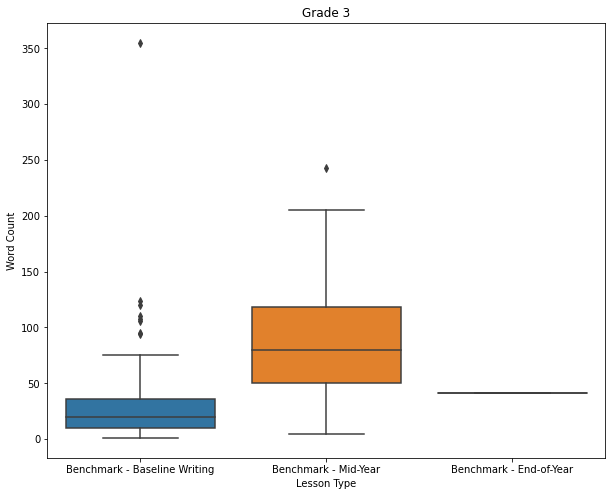

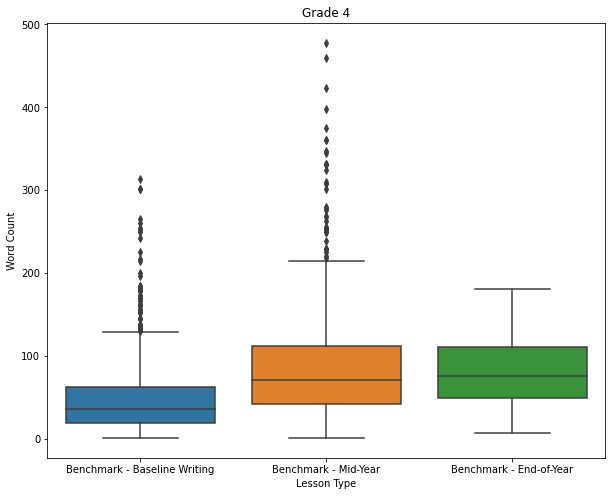

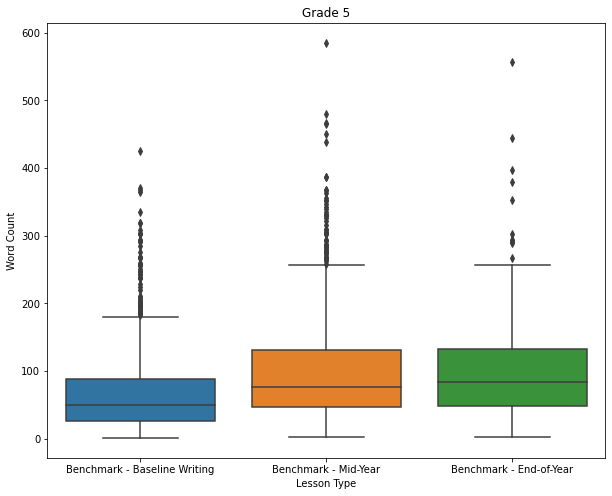

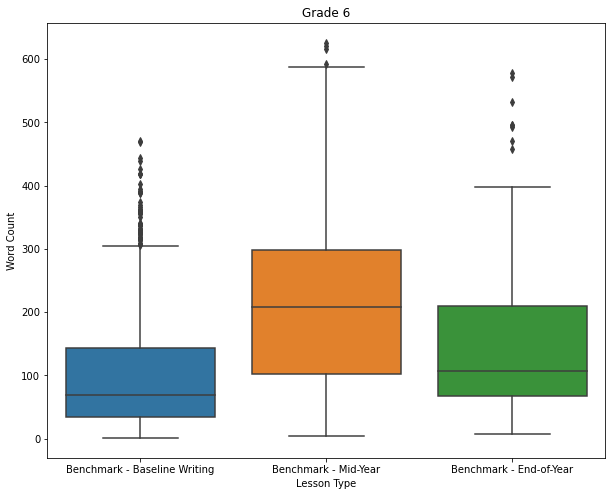

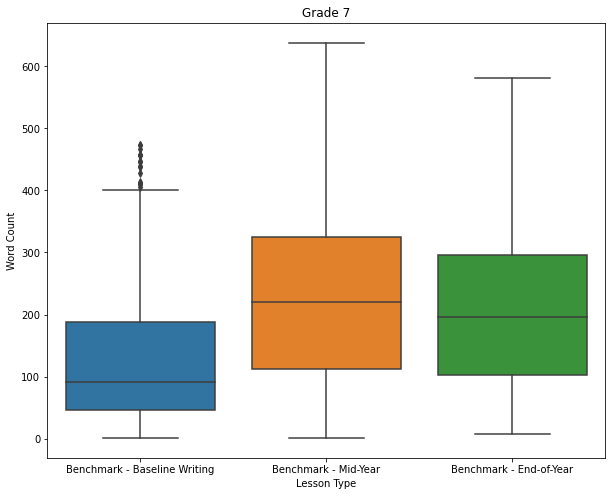

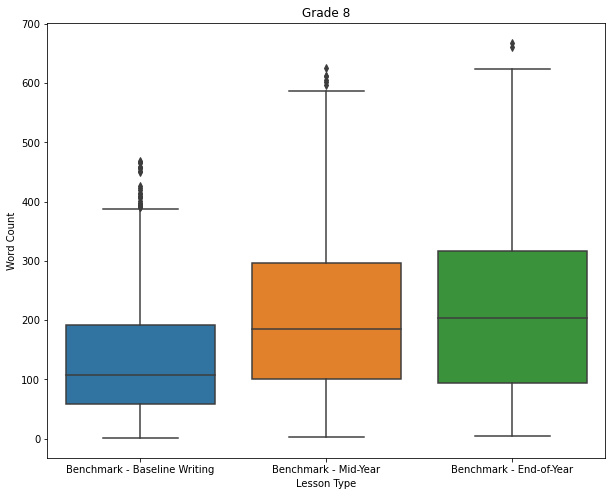

In [14]:
# boxplot: writing scores by boy, moy and eoy (for each grade)
plt.figure(figsize = (10,8))

for n in range(3,9): 
    plt.figure(figsize = (10,8))
    # choose the grade  
    grade = bchmrk[bchmrk['Enrolled Grade']==n] 
    
    ax = sns.boxplot(x=grade['Lesson Type'],y=grade['Word Count'])
    ax.set_title('Grade %d' %n)
#     plt.savefig('/Users/spencersu/Desktop/JCPS Efficacy Report/Datasets/boxplot grade' + str(n) +'.png')
    plt.show()

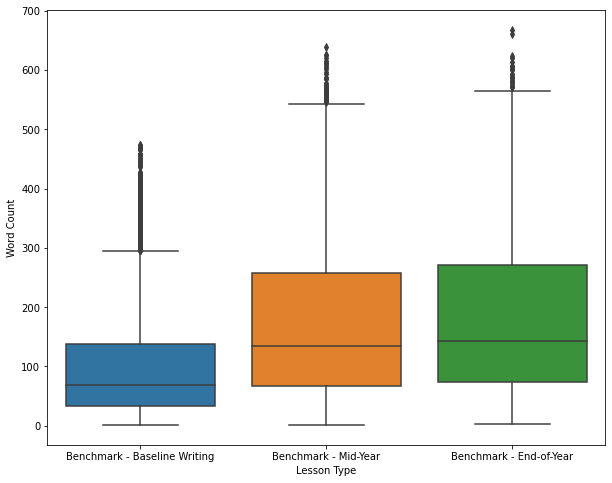

In [15]:
plt.figure(figsize = (10,8))
ax = sns.boxplot(x=bchmrk['Lesson Type'],y=bchmrk['Word Count'])
plt.show()

## Scatterplot (usage vs. word count)

In [16]:
bchmrk_p['growth'] = bchmrk_p['Benchmark - Mid-Year'] - bchmrk_p['Benchmark - Baseline Writing']

## count the number of writing lessons a student submit 

num_wrtlsn = wrtlsn.groupby(['School Year','School Name','Full Name','Enrolled Grade'])['Student Assignment ID'].count()
num_wrtlsn = num_wrtlsn.reset_index()
num_wrtlsn.rename(columns={'Student Assignment ID': 'num_asgmt'}, inplace = True)

bchmrk_p = pd.merge(bchmrk_p,num_wrtlsn,on=['School Year','School Name','Full Name','Enrolled Grade'], how='inner')

# 277 rows × 10 columns

In [17]:
bchmrk_p = bchmrk_p[(bchmrk_p['School Year'] != '2019-2020') & (bchmrk_p['Enrolled Grade'] != 3)]

# 153 rows × 9 columns

In [18]:
bchmrk_p

,School Year,School Name,Full Name,Enrolled Grade,Benchmark - Baseline Writing,Benchmark - End-of-Year,Benchmark - Mid-Year,growth,num_asgmt
14,2020-2021,Animas Elementary,Elliot Gilbreath,5,11.0,291.0,62.0,51.0,1
15,2020-2021,Animas Elementary,Ezrae Austin,5,63.0,127.0,56.0,-7.0,1
16,2020-2021,Animas Elementary,Iliyahana Benally,5,30.0,197.0,142.0,112.0,1
17,2020-2021,Animas Elementary,Izabella Figueroa,5,51.0,228.0,203.0,152.0,1
18,2020-2021,Animas Elementary,Jaden Aspaaswise,5,7.0,165.0,28.0,21.0,1
...,...,...,...,...,...,...,...,...,...
162,2020-2021,Tibbetts Middle School,Mckenzee Hosteen,8,254.0,169.0,21.0,-233.0,2
163,2020-2021,Tibbetts Middle School,Owyn Churchill,8,106.5,225.0,103.0,-3.5,1
164,2020-2021,Tibbetts Middle School,Ryley Hamilton,8,323.0,284.0,327.0,4.0,1
165,2020-2021,Tibbetts Middle School,Shawndae Haungooah,8,313.0,404.0,337.0,24.0,1


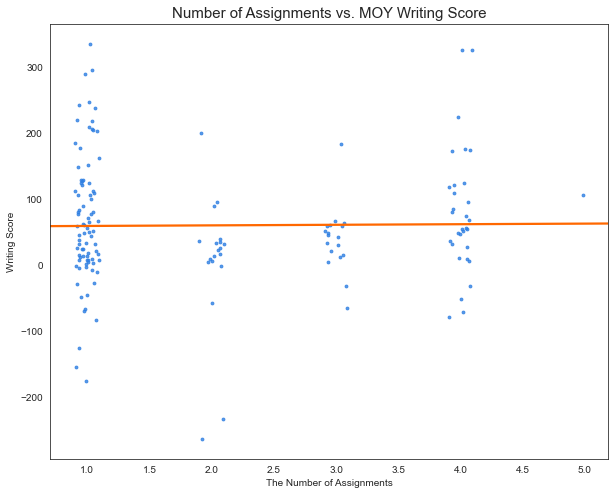

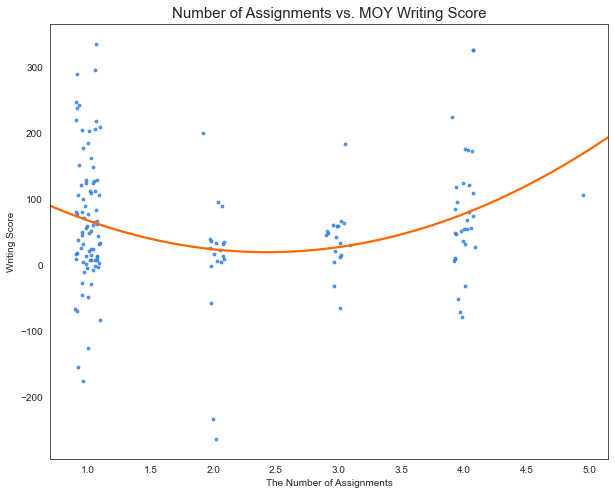

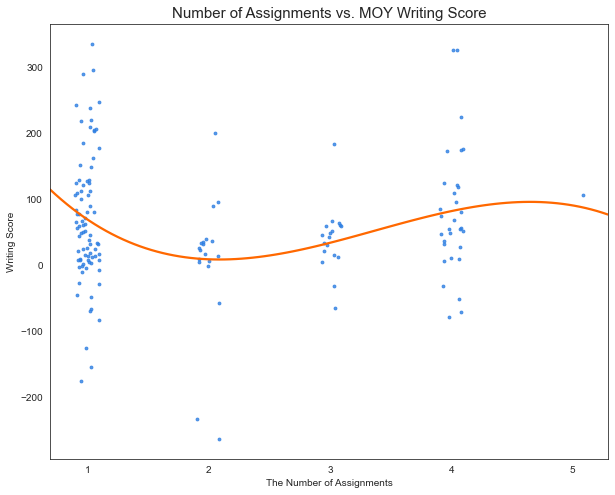

In [19]:
for n in range (1,4):
    sns.set_style(style='white')
    plt.figure(figsize = (10,8))
    sns.regplot(bchmrk_p['num_asgmt'],bchmrk_p['growth'], order = n,
                scatter_kws={"color": "#2f7fe2",'s':8}, truncate = False, x_jitter=.1,marker='o',
                line_kws={"color": "#ff6800"}, ci=None)
    plt.xlabel('The Number of Assignments')
    plt.ylabel('Writing Score')
    plt.title("Number of Assignments vs. MOY Writing Score", fontsize=15)
#     plt.savefig(os.path.join(path,'The Number of Assignments vs. MOY Writing Score (Order ' + str(n) +').png'))
    plt.show()

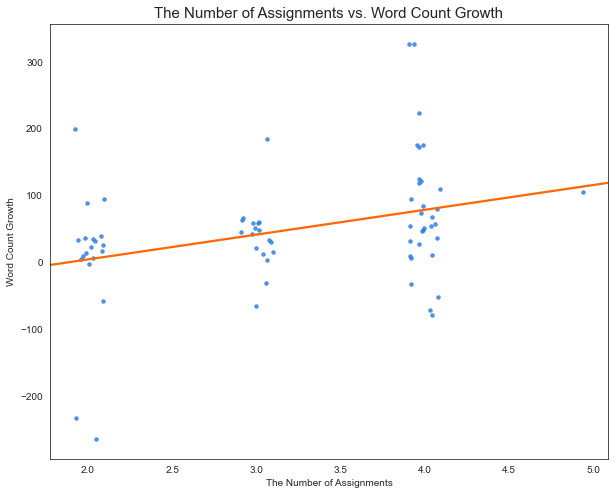

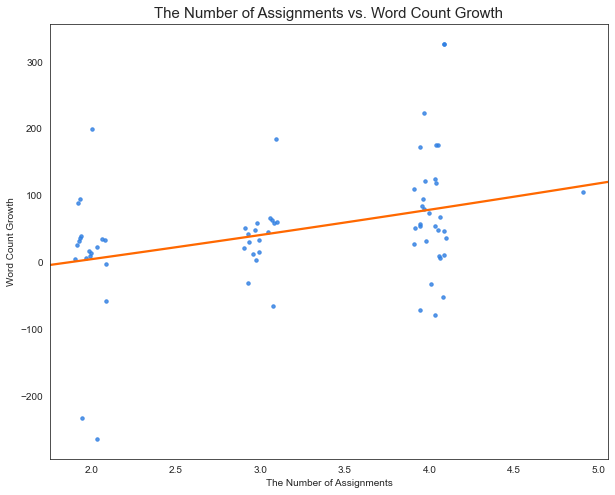

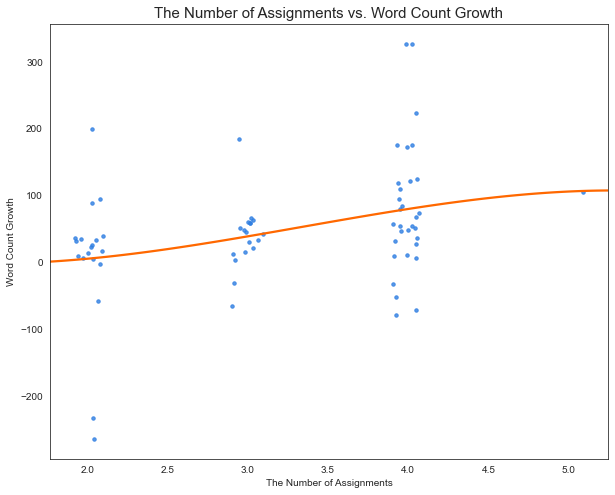

In [20]:
bchmrk_usage = bchmrk_p[bchmrk_p['num_asgmt'] >1]

for n in range (1,4):
    sns.set_style(style='white')
    plt.figure(figsize = (10,8))
    sns.regplot(bchmrk_usage['num_asgmt'],bchmrk_usage['growth'], order = n,
                scatter_kws={"color": "#2f7fe2",'s':12}, truncate = False, x_jitter=.1,marker='o',
                line_kws={"color": "#ff6800"}, ci=None)
    plt.xlabel('The Number of Assignments')
    plt.ylabel('Word Count Growth')
    plt.title("The Number of Assignments vs. Word Count Growth", fontsize=15)
#     plt.savefig(os.path.join(path,'The Number of Assignments vs. MOY Writing Score (Order ' + str(n) +').png'))
    plt.show()

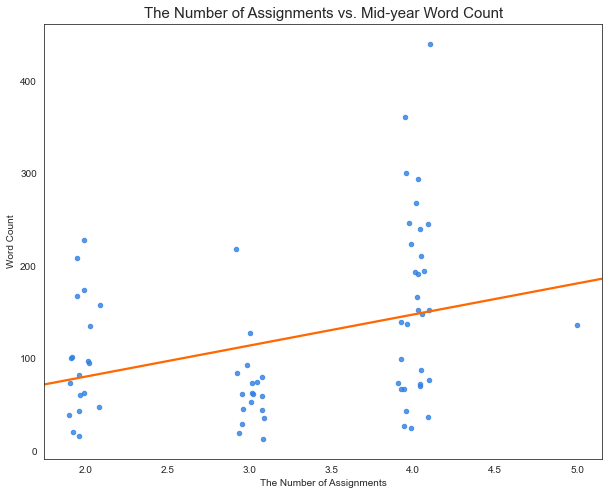

In [21]:
sns.set_style(style='white')
plt.figure(figsize = (10,8))
sns.regplot(bchmrk_usage['num_asgmt'],bchmrk_usage['Benchmark - Mid-Year'], order = 1,
            scatter_kws={"color": "#2f7fe2",'s':20}, truncate = False, x_jitter=.1,marker='o',
            line_kws={"color": "#ff6800"}, ci=None)
plt.xlabel('The Number of Assignments')
plt.ylabel('Word Count')
plt.title("The Number of Assignments vs. Mid-year Word Count", fontsize=15)
plt.savefig(os.path.join(path,'Assignments vs Word Count.png'))
plt.show()

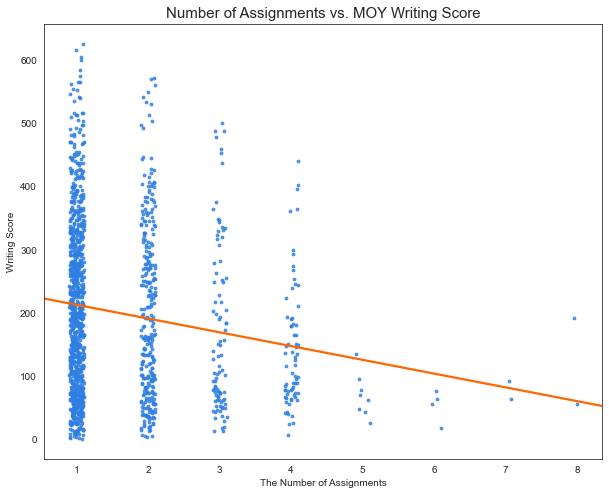

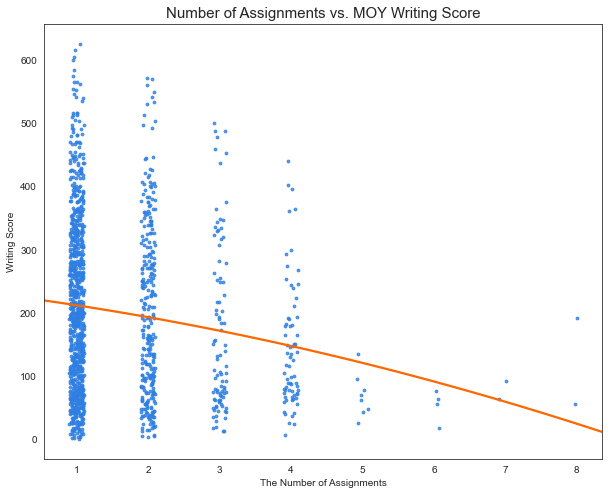

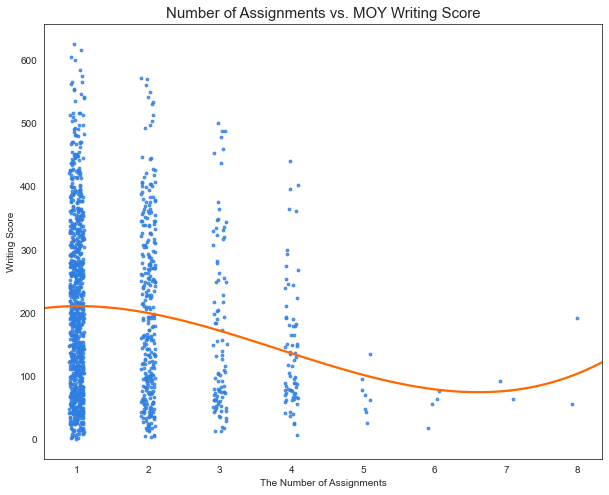

In [22]:
bchmrk_wrt = pd.merge(bchmrk,num_wrtlsn,on=['School Year','School Name','Full Name','Enrolled Grade'], how='inner')

# 3365 rows × 14 columns

midyear = bchmrk_wrt[bchmrk_wrt['Lesson Type'] == 'Benchmark - Mid-Year']
for n in range (1,4):
    sns.set_style(style='white')
    plt.figure(figsize = (10,8))
    sns.regplot(midyear['num_asgmt'],midyear['Word Count'], order = n,
                scatter_kws={"color": "#2f7fe2",'s':8}, truncate = False, x_jitter=.1,marker='o',
                line_kws={"color": "#ff6800"}, ci=None)
    plt.xlabel('The Number of Assignments')
    plt.ylabel('Writing Score')
    plt.title("Number of Assignments vs. MOY Writing Score", fontsize=15)
#     plt.savefig(os.path.join(path,'The Number of Assignments vs. MOY Writing Score (Order ' + str(n) +').png'))
    plt.show()

## Regression (Usage vs. Scores)

In [23]:
df_reg = bchmrk_usage.rename(columns={bchmrk_usage.columns[0]: 'school_year', 
                                      bchmrk_usage.columns[1]: 'school_name',
                                      bchmrk_usage.columns[2]: 'full_name',
                                      bchmrk_usage.columns[3]: 'enrolled_grade',
                                      bchmrk_usage.columns[4]: 'baseline_wordcount',
                                      bchmrk_usage.columns[4]: 'endyear_wordcount',
                                      bchmrk_usage.columns[4]: 'midyear_wordcount'}, inplace = False)

In [24]:
results = smf.ols('growth ~ num_asgmt + C(enrolled_grade) + C(school_name)', data=df_reg).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 growth   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     2.272
Date:                Thu, 14 Apr 2022   Prob (F-statistic):             0.0579
Time:                        11:27:50   Log-Likelihood:                -404.32
No. Observations:                  69   AIC:                             820.6
Df Residuals:                      63   BIC:                             834.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------